#### Importing Libraries

In [74]:
# import all libraries needed
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.optimizers import Adam, SGD, Adagrad, Adamax, RMSprop
from sklearn.metrics import classification_report
import os
import zipfile
import shutil
import splitfolders
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, GlobalMaxPool2D, SpatialDropout2D, BatchNormalization, AveragePooling2D, GlobalAvgPool2D, Dropout
from sklearn.preprocessing import LabelEncoder

In [112]:
data_dir = os.path.join('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/dataset')
output = os.path.join('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/dataset_split')
splitfolders.ratio(data_dir, output=output, seed=42, ratio=(0.7, 0.1, 0.2)) 

Copying files: 13808 files [00:11, 1240.17 files/s]


In [126]:
# create train, val paths
base_dir = 'C:\TUGASKYU\SMT 7\Praktikum Machine Learning\dataset_split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [127]:
# gather train dataset
trainX = []
trainY = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            trainX.append(image)
            label = imagePath.split(os.path.sep)[-2]
            trainY.append(label)

trainX = np.array(trainX)
trainY = np.array(trainY)

In [128]:
# gather validation data
valX = []
valY = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            valX.append(image)
            label = imagePath.split(os.path.sep)[-2]
            valY.append(label)

valX = np.array(valX)
valY = np.array(valY)

In [129]:
# gather validation data
testX = []
testY = []
for r, d, f in os.walk(test_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            testX.append(image)
            label = imagePath.split(os.path.sep)[-2]
            testY.append(label)

testX = np.array(testX)
testY = np.array(testY)

In [132]:
# check shape of each images in train & val dataset
print("Train Data=", trainX.shape)
print("Train Label=", trainY.shape)
print("Validation Data=", valX.shape)
print("Validation Label=", valY.shape)
print("Test Data=", testX.shape)
print("Test Label=", testY.shape)

Train Data= (12551, 150, 150, 3)
Train Label= (12551,)
Validation Data= (2613, 150, 150, 3)
Validation Label= (2613,)
Test Data= (4962, 150, 150, 3)
Test Label= (4962,)


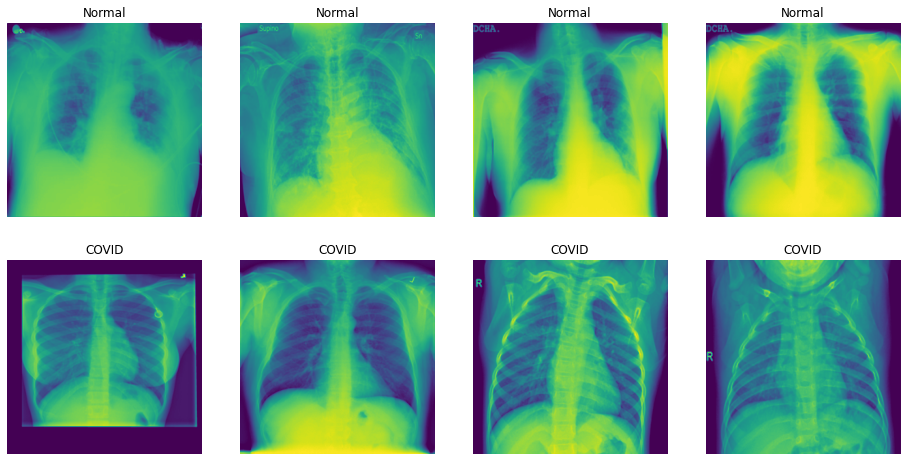

In [141]:
%matplotlib inline


train_COVID_dir = os.path.join('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/dataset_split/train/COVID')
train_Normal_dir = os.path.join('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/dataset_split/train/Normal')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 2
ncols = 4

pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 4

next_COVID_pix = [os.path.join(train_COVID_dir, fname)
                        for fname in os.listdir(train_COVID_dir)[pic_index-4:pic_index]]
next_Normal_pix = [os.path.join(train_Normal_dir, fname)
                       for fname in os.listdir(train_Normal_dir)[pic_index-4:pic_index]]

for i, img_path in enumerate(next_COVID_pix+next_Normal_pix):
    # Set up subplot; subplot indices start at 1
    if(i < 4) :
        title = "Normal"
    else:
        title = "COVID"
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.title(title)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [142]:
# label encoder implementation in each train & validation label
lb = LabelEncoder()
trainY = lb.fit_transform(trainY)
valY = lb.fit_transform(valY)

In [150]:
# normalize the scale in every images using ImageDataGenerator
datagen = ImageDataGenerator( rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  validation_split = 0.25)
# implement ImageDataGenerator in train, test data, & each label
train_iterator = datagen.flow(trainX, trainY, batch_size=128)
val_iterator = datagen.flow(valX, valY, batch_size=128)
print('Batches train=%d, validation=%d' % (len(train_iterator), len(val_iterator)))

Batches train=99, validation=21


In [151]:
# check maximum & minimum scale of each images
print('Train min=%.f, max=%.f' % (trainX.min(), trainX.max()))
print('Validation min=%.f, max=%.f' % (valX.min(), valX.max()))
     

Train min=0, max=255
Validation min=0, max=255


In [145]:
# check minimum & maximum scale after normalize each images
batchX, batchy = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(64, 150, 150, 3), min=0.000, max=1.000


Model 1

In [152]:
model = Sequential()
model.add(InputLayer(input_shape=[150, 150, 3]))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(SpatialDropout2D(rate=0.5))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(SpatialDropout2D(rate=0.5))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(Flatten())

# fully connected
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 spatial_dropout2d_2 (Spatia  (None, 150, 150, 16)     0         
 lDropout2D)                                                     
                                                                 
 batch_normalization_3 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 32)        4640      
                                                      

In [153]:
# compile model
model.compile(optimizer='Adagrad', loss='binary_crossentropy', metrics=['accuracy'])

In [154]:
# training & saving history of every epoch
H = model.fit(train_iterator, epochs=100, validation_data=val_iterator, verbose=1)

Epoch 1/100
99/99 [==============================] - 280s 3s/step - loss: 0.7023 - accuracy: 0.5794 - val_loss: 0.6594 - val_accuracy: 0.6766
Epoch 2/100
99/99 [==============================] - 264s 3s/step - loss: 0.6438 - accuracy: 0.6353 - val_loss: 0.6209 - val_accuracy: 0.7543
Epoch 3/100
99/99 [==============================] - 264s 3s/step - loss: 0.6140 - accuracy: 0.6642 - val_loss: 0.5687 - val_accuracy: 0.7643
Epoch 4/100
99/99 [==============================] - 255s 3s/step - loss: 0.5952 - accuracy: 0.6821 - val_loss: 0.5428 - val_accuracy: 0.7757
Epoch 5/100
99/99 [==============================] - 245s 2s/step - loss: 0.5825 - accuracy: 0.6929 - val_loss: 0.5329 - val_accuracy: 0.7799
Epoch 6/100
99/99 [==============================] - 256s 3s/step - loss: 0.5655 - accuracy: 0.7129 - val_loss: 0.5199 - val_accuracy: 0.7796
Epoch 7/100
99/99 [==============================] - 262s 3s/step - loss: 0.5618 - accuracy: 0.7131 - val_loss: 0.5130 - val_accuracy: 0.7853
Epoch 

In [155]:
model.save('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/Kelompok/Modul 2 Model 1.h5')

In [193]:
from tensorflow.keras.models import load_model
load_modelLRS = load_model('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/Kelompok/Modul 2 Model 1.h5')
load_modelLRS.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 spatial_dropout2d_2 (Spatia  (None, 150, 150, 16)     0         
 lDropout2D)                                                     
                                                                 
 batch_normalization_3 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 32)        4640      
                                                      

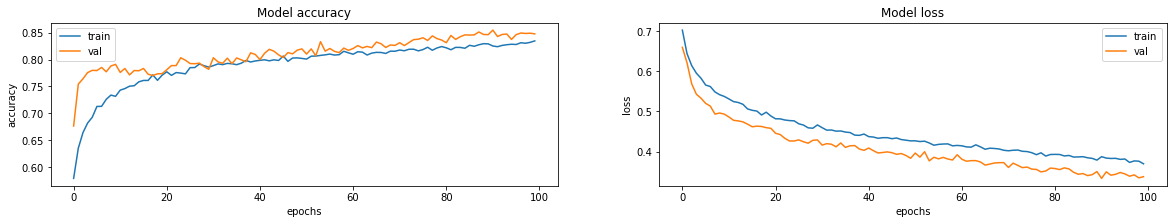

In [156]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(H.history[met])
    ax[i].plot(H.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [158]:
# build a simple model
model2 = Sequential()
model2.add(InputLayer(input_shape=[150, 150, 3]))
model2.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(SpatialDropout2D(rate=0.5))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(SpatialDropout2D(rate=0.5))
model2.add(BatchNormalization())
model2.add(GlobalAvgPool2D())
model2.add(Flatten())

# fully connected
model2.add(Dense(64, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 spatial_dropout2d_4 (Spatia  (None, 150, 150, 16)     0         
 lDropout2D)                                                     
                                                                 
 batch_normalization_6 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 150, 150, 32)     

In [161]:
model2.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])

In [166]:
# training & saving history of every epoch
H2 = model2.fit(train_iterator, steps_per_epoch= 35, epochs=100, validation_data=val_iterator, verbose=1)

Epoch 1/100
35/35 [==============================] - 348s 10s/step - loss: 0.5807 - accuracy: 0.7333 - val_loss: 0.5741 - val_accuracy: 0.7390
Epoch 2/100
35/35 [==============================] - 347s 10s/step - loss: 0.5906 - accuracy: 0.7230 - val_loss: 0.5733 - val_accuracy: 0.7390
Epoch 3/100
35/35 [==============================] - 349s 10s/step - loss: 0.5863 - accuracy: 0.7279 - val_loss: 0.5727 - val_accuracy: 0.7390
Epoch 4/100
35/35 [==============================] - 320s 9s/step - loss: 0.5733 - accuracy: 0.7348 - val_loss: 0.5710 - val_accuracy: 0.7390
Epoch 5/100
35/35 [==============================] - 317s 9s/step - loss: 0.5774 - accuracy: 0.7348 - val_loss: 0.5691 - val_accuracy: 0.7390
Epoch 6/100
35/35 [==============================] - 317s 9s/step - loss: 0.5794 - accuracy: 0.7292 - val_loss: 0.5684 - val_accuracy: 0.7390
Epoch 7/100
35/35 [==============================] - 318s 9s/step - loss: 0.5683 - accuracy: 0.7368 - val_loss: 0.5638 - val_accuracy: 0.7390
Epo

In [ ]:
model.save('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/Kelompok/Modul 2 Model 2.h5')

In [177]:
from tensorflow.keras.models import load_model
load_modelLRS = load_model('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/Kelompok/Modul 2 Model 2.h5')
load_modelLRS.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 spatial_dropout2d_2 (Spatia  (None, 150, 150, 16)     0         
 lDropout2D)                                                     
                                                                 
 batch_normalization_3 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 32)        4640      
                                                      

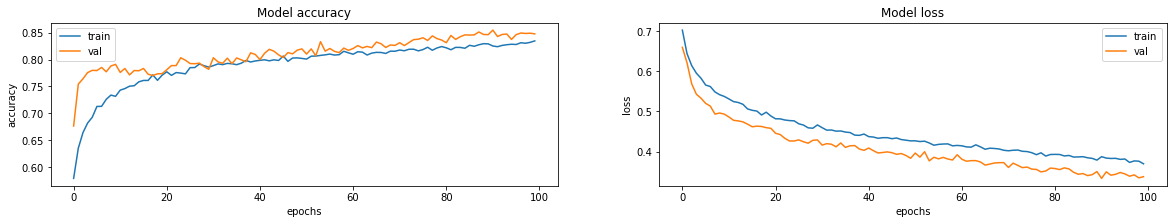

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(H.history[met])
    ax[i].plot(H.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])